# Exercise Sheet No. 7

---

> Machine Learning for Natural Sciences, Summer 2021, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Deadline: 07.06.2021, 8 am
> 
> Tutor: patrick.reiser@kit.edu  
> **Please ask questions in the forum and only contact the Tutor when there are issues with the grading**

---
**Topic**: This exercise sheet will use neural networks for a molecular dynamics simulation

# Molecular dynamics simulation

"Molecular dynamics (MD) is a computer simulation method for analyzing the physical movements of atoms and molecules. (...)  In the most common version, the trajectories of atoms and molecules are determined by numerically solving Newton's equations of motion for a system of interacting particles, where forces between the particles and their potential energies are often calculated using interatomic potentials or molecular mechanics force fields." [wikipedia](https://en.wikipedia.org/wiki/Molecular_dynamics)

In this exercise we will perform a MD simulation of a single very simple molecule, namely methanol (CH3OH). The propagation of the atomic positions in time is usually treated classically and is given by Newton's Equation for an ensemble of particles:

$$ F(X) = - \nabla U(X) = M \dot{V}(t)$$

$$ V(t) = \dot{X}(t) $$

A molecular dynamics simulation therfore requires the definition of a potential function $U(X)$, or a description of the force terms $F(X)$ by which the particles in the simulation will interact. To correctly capture the molecular interactions, different methods are used for MD simulations, depending on system. The most common are:

* Force fields in chemistry are empirical and consist of a summation of bonded forces associated with chemical bonds, bond angles, and bond dihedrals, and non-bonded forces associated with van der Waals forces and electrostatic charge. They are the most used interaction modelling technique for MD.

* Pair potentials between particles, in which the total potential energy can be calculated from the sum of energy contributions between pairs of atoms. An example of such a pair potential is the non-bonded Lennard–Jones potential.

* Semi-empirical potentials are based on quantum methods, but use empirical formula to determine the energy contributions of the orbitals, e.g. tight-binding potentials

*  Ab Initio Molecular Dynamics (AIMD) use quantum mechanical methods for the energy potential, which is more accurate and can describe bond-breaking etc. but which is also much more expensive.

* QM/MM methods are hybrids between quantum mechanical (QM) and molecular or classical mechanics (MM), where only a small (and important) part is QM.

The goal of this exercise is to derive the correct potential energy by a neural network, which is fast in prediction and, if trained on quantum mechanical (QM) calculations, also ideally as precise a AIMD/QM methods. Only with QM calculations effects such as bond breaking and reactions can be captured in a MD simulation. To work for arbitrary molecules and inter-molecular interactions the neural network potentials have to be convolutional (e.g. deep convolutional filter or graph networks) or atom-centered but which goes beyond the scope of this exercise. 

Why do we want to use Neural networks for MD simulations?

1. Because Neural networks are always cool.
2. Neural networks are fast in prediction and in principle differentiable and could have QM accuracy if trained on QM data.
3. Force Fields do not work in MD simulation

In [11]:
answer_md = 0 # please pick your answer
# YOUR CODE HERE
answer_md = 2

In [12]:
# 1 Point
assert answer_md != 0

We start with loading and inspecting different geometries of methanol that has been sampled via distorting the molecule. A very common format are `.xyz` files. The format of a single xyz-file is:
1. Line:              Number of atoms  (int)
2. Line:              comment         (string)
3. Line and following: Element and x- y- z-coordinates (string and float)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

molecule_name = "methanol"

In [14]:
# Read xyz
def load_csv(filepath, delimeter=" "):
    values = []
    # open file
    infile = open(filepath,"r")
    lines = infile.readlines()
    # read separate entries
    for line in lines:
        line_list = line.strip().split(delimeter)
        line_list = [x.strip() for x in line_list if x != '']
        values.append(line_list)
    # close file
    infile.close()
    return values

In [15]:
lines = load_csv(molecule_name+"_conformers.xyz")
lines[:15]

[['6'],
 [],
 ['C', '-0.37100', '0.00770', '-0.00860'],
 ['O', '0.91670', '-0.50480', '-0.29720'],
 ['H', '-0.52000', '0.03280', '1.07370'],
 ['H', '-0.46500', '1.01430', '-0.42340'],
 ['H', '-1.12230', '-0.64270', '-0.46260'],
 ['H', '1.56170', '0.09260', '0.11810'],
 ['6'],
 [],
 ['C', '0.00000', '0.00000', '0.00000'],
 ['O', '1.46290', '0.00000', '0.00000'],
 ['H', '-0.20120', '0.00000', '-1.06120'],
 ['H', '-0.39850', '-0.92730', '0.18950'],
 ['H', '-0.47420', '0.67650', '0.67230']]

Now your task is to split separated lines into a nested list that runs over the molecules and looks like the example below. The coordinates shoud be given as floats and the comment line removed. The number of atoms tells you how many lines to add to the list. Note: your function should also work for arbitrary number of molecules and with different number of atoms in the same xyz-file.
```
[[['C', -0.371, 0.0077, -0.0086],
  ['O', 0.9167, -0.5048, -0.2972],
  ['H', -0.52, 0.0328, 1.0737],
  ['H', -0.465, 1.0143, -0.4234],
  ['H', -1.1223, -0.6427, -0.4626],
  ['H', 1.5617, 0.0926, 0.1181]],
 [['C', 0.0, 0.0, 0.0],
  ['O', 1.4629, 0.0, 0.0],
  ['H', -0.2012, 0.0, -1.0612],
  ['H', -0.3985, -0.9273, 0.1895],
  ['H', -0.4742, 0.6765, 0.6723],
  ['H', 1.6591, -0.7102, -0.5943]], ...]
```

In [64]:
def lines_to_xyz(values):
    # Parse mols with flexible size
    # YOUR CODE HERE
    
    def val(arr):
        return [arr[0]] + [float(r) for r in arr[1:4]]
    
    convert_list = []
    elem_idx = 0

    while elem_idx < len(values):
        
        elem = values[elem_idx][0]
        if elem.isnumeric():
            atoms = int(elem)
            
            # copy atoms
            atom_arrs = values[elem_idx+2:elem_idx+2+atoms]
            
            # append these values to the list -- can't ever re-read this line
            convert_list.append([val(arr) for arr in atom_arrs])
            
            # jump to next number definition
            elem_idx += 2 + atoms
        
        else:
            break
            
        pass
    
    return convert_list

In [65]:
mols = lines_to_xyz(lines)

In [66]:
# 2 Points
assert np.sum(np.abs(np.array(mols[1][2][1:]) - np.array([-0.2012, 0.0, -1.0612]))) < 0.001
assert mols[0][1][0] == 'O' and mols[0][3][0] == 'H'

In [67]:
# 2 Points
assert lines_to_xyz([['1'],['my Comment'],['C','0.0','0.0','0.0'],
              ['2'],['my Comment'],['C','0.0','0.0','0.0'],['O','1.0','1.0','1.0']])[1][1][0] == 'O'
assert lines_to_xyz([['1'],['my Comment'],['C','0.0','0.0','0.0'],
              ['2'],['my Comment'],['C','0.0','0.0','0.0'],['O','1.0','1.0','1.0']])[1][1][1] - 1.0 < 1e-5

# 1. Learn Energies and Gradients of the molecule

## 1.1 Load Data

So that you can continue without solving previous exercise, load the numpy arrays below.

In [10]:
# Already prepared
import numpy as np
geos = np.load(molecule_name+"_coordinates.npy") # in A
energies = np.load(molecule_name+"_energy.npy") # in eV
grads = np.load(molecule_name+"_gradients.npy")*27.21138624598853/0.52917721090380 # from H/B to eV/A

## 1.2 Train-Test-Split

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf

In [12]:
# Scale energy and make test split
scaler = StandardScaler(with_std=True, with_mean=True, copy=True)

energy_scaled = scaler.fit_transform(energies[:, np.newaxis])
grads_scaled = grads / scaler.scale_

train_x, test_x, train_g, test_g, train_e, test_e = train_test_split(geos, grads_scaled, energy_scaled, test_size=0.2, shuffle=True, random_state=42)
print(train_e.shape)
print(test_g.shape)

(4800, 1)
(1201, 6, 3)


Now in principle you could already set up a model with TensorFlow-Keras as shown below which simply takes all coordinates as input. You can test it with the data above, but please remove your code again for submission. 
Please have a look at the tensorflow api documentation: https://www.tensorflow.org/api_docs

Here we created a tensorflow model by sequentially setting up the layers of the model. The input tensor is passed from layer to layer within the model. The first dimension is always the batch dimension.
A fully connected neural network is given by `tf.keras.layers.Dense`. With the input-layer we define the input shape from which the hidden weights can be built (Note: you have to call the model once for the weights to actually being initalized). Since we want to use the neural network to model a smooth potential, we will not use "relu" but "selu". We use a regularizer for the kernel-weights.

In [13]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(6,3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300,use_bias=True, activation="selu", kernel_regularizer=tf.keras.regularizers.L1(1e-5)))
model.add(tf.keras.layers.Dense(300,use_bias=True, activation="selu", kernel_regularizer=tf.keras.regularizers.L1(1e-5)))
model.add(tf.keras.layers.Dense(1,use_bias=True,activation="linear"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 300)               5700      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 96,301
Trainable params: 96,301
Non-trainable params: 0
_________________________________________________________________


What could be the problem in this approach? Choose one of the anserwers:

1. The model does not have trainable weights.
2. The model can not deal with input tensor of rank > 1.
3. The model has input features that are not rotation and translation invariant but the model output is.

In [14]:
answer_model_1 = 0 # please pick an answer as int
# YOUR CODE HERE
answer_model_1 = 3

In [15]:
# 1 Point
assert answer_model_1 != 0

## 1.3 Features

With deep-learning APIs like TensorFlow, gradients and jacobians can be computed analytically. We make use of this to compute gradients or forces based on the Neural Network potential. This is further helpful since the gradients a vector properties and will depend on the orientation (not translation) of the molecule. However, to this end, we have to compute the feature descriptors within the model. 

We will do this within a layer named `InverseDistances`. The subclassed layer backbone is shown below. The backward pass is completely taken care of by tensorflow, as long as you use tensorflow functions that have a gradient defined: https://www.tensorflow.org/guide/autodiff

In [23]:
class InverseDistances(tf.keras.layers.Layer):
    
    def __init__(self, pair_indices = None, **kwargs):
        super(InverseDistances, self).__init__(**kwargs)
        
        self.pair_indices = pair_indices

    def build(self, input_shape):
        
        if self.pair_indices is None:
            self.pair_indices = np.array([[i,j] for i in range(input_shape[1]) for j in range(i)], dtype=np.int64)
        else:
            self.pair_indices = np.array(self.pair_indices, dtype=np.int64)
            
        self.tf_pair_indices = self.add_weight('pair_indices',
                                               shape=self.pair_indices.shape,
                                               initializer=tf.keras.initializers.Zeros(),
                                               dtype='int64',
                                               trainable=False)

        super(InverseDistances, self).build(input_shape)
        
        self.set_weights([self.pair_indices])
        
    def call(self, inputs, **kwargs):
        
        # Translate the numpy version of the forward layer pass to tensorflow functions
        # Find the appropriate tensorflow functions. Everything must be vectorized.
        cordbatch = inputs
        indexbatch = self.pair_indices
        
        v1 = tf.gather(cordbatch, indexbatch[:, 0], axis=1)
        v2 = tf.gather(cordbatch, indexbatch[:, 1], axis=1)
        vec = v2 - v1
        norm_vec = tf.sqrt(tf.reduce_sum(vec * vec, axis=-1))
        invd_out = 1/norm_vec
        return invd_out
    
    def _call_numpy_version_not_use(self, inputs):
        # The same as call with numpy
        cordbatch = inputs
        indexbatch = self.pair_indices # You may have to add a dimension to indices for tf
        v1 = np.take(cordbatch, indexbatch[:,0],axis=1) # You have to find a solution with tf.gather here
        v2 = np.take(cordbatch, indexbatch[:,1],axis=1) # For tf check out the batch_dims and axis parameter for tf.gather
        vec = v2-v1
        norm_vec = np.sqrt(np.sum(vec*vec,axis=-1))
        invd_out = 1/norm_vec
        return invd_out

In [24]:
# Test layer
test_layer = InverseDistances(dtype='float64')
test_layer.build(geos[:10,:,:].shape)
result_test_layer = test_layer(geos[:10,:,:]).numpy()
result_test_numpy = test_layer._call_numpy_version_not_use(geos[:10,:,:])
result_test_numpy.shape

(10, 15)

In [25]:
# 3 Points
assert np.sum(np.abs(result_test_layer-result_test_numpy))< 1e-6

In principle we can make now a model like shown below. However, it turns out that training with the prediction of the gradients leads to overall better results. Note the non-trainable weights for the indices that come from our custom layer.

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(6,3)))
model.add(InverseDistances(name="InverseDistance"))
model.add(tf.keras.layers.Dense(300,use_bias=True, activation="selu", kernel_regularizer=tf.keras.regularizers.L1(1e-5)))
model.add(tf.keras.layers.Dense(300,use_bias=True, activation="selu", kernel_regularizer=tf.keras.regularizers.L1(1e-5)))
model.add(tf.keras.layers.Dense(1,use_bias=True,activation="linear"))
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InverseDistance (InverseDist (None, 15)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 300)               4800      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 95,431
Trainable params: 95,401
Non-trainable params: 30
_________________________________________________________________


Why could it be more advantageous to train with energy AND forces as model output?

1. The forces are not connected to the energies and therefore needs to be in the training set.
2. Adding the forces makes training much faster
3. The gradients determine the slope of the potential energy surface and act as an additional form of regularization.

In [27]:
answer_gradient = 0 # select the number of the correct answer
# YOUR CODE HERE
answer_gradient = 3

In [28]:
# 1 Point
assert answer_gradient != 0

## 1.4 Energy + Gradients

We can improve the gradient prediction if we train on energies and gradients simultaneously. To do this the analytical gradient prediction has to be integrated into the model. A subclassing of a tf.keras.model allows for implementing a more general model definition than the simply sequential model constructor.

In [29]:
class EnergyGradientModel(tf.keras.Model):

    def __init__(self, **kwargs):

        super(EnergyGradientModel, self).__init__(**kwargs)

        self.feat_layer = InverseDistances()
        
        self.dense_layers = [ tf.keras.layers.Dense(300,use_bias=True, activation="selu", kernel_regularizer=tf.keras.regularizers.L1(1e-5)),
                          tf.keras.layers.Dense(300,use_bias=True, activation="selu", kernel_regularizer=tf.keras.regularizers.L1(1e-5))
                          ]

        self.energy_layer = tf.keras.layers.Dense(1,use_bias=True,activation="linear")
        
    def call(self, inputs, training=False, **kwargs):
        
        x = inputs
        with tf.GradientTape() as tape:
            tape.watch(x)
            hidden = self.feat_layer(x)
            for d in self.dense_layers:
                hidden = d(hidden, training=training)
            temp_e = self.energy_layer(hidden)
        temp_g = tape.batch_jacobian(temp_e,x)
        temp_g = temp_g[:,0,:,:]
        return [temp_e, temp_g]

In [30]:
model = EnergyGradientModel()
model.build(train_x.shape)

In [32]:
# Compile and Training of the model
def compile_train_model(model,x,y,
                        validation_data=None,
                        epochs=1000,
                        lr=0.5e-3,
                        validation_freq=10,
                        batch_size=128,
                        verbose=2,
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'],
                        loss_weights=None):

    # Compile model with optimizer and learning rate
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics,
                  loss_weights=loss_weights)

    hist = model.fit(x,y,epochs=epochs,
                     batch_size=batch_size,
                     validation_freq=validation_freq,
                     validation_data=validation_data,
                     verbose=2)
    
    return hist

Please submit your solution with `do_training = False`.

In [37]:
do_training = False
# YOUR CODE HERE
# do_training = True

In [ ]:
if do_training:
    hist = compile_train_model(model,train_x,
                               [train_e, train_g],
                               validation_data=(test_x,[test_e, test_g]),
                               loss=["mean_squared_error","mean_squared_error"],
                               metrics=[['mean_absolute_error'],['mean_absolute_error']],
                               loss_weights=[1,5]
                              )

In [35]:
# Some plotting functions.
def plot_history(hist, validation_freq=10,scale=1):    
    plt.figure()
    for key, loss in hist.history.items():
        np_loss=np.array(loss)
        if "val" in key:
            plt.plot(np.arange(np_loss.shape[0])*validation_freq+validation_freq,np_loss, label=key)
        else:
            plt.plot(np.arange(np_loss.shape[0]), np_loss, label=key)
        
    plt.xlabel('Epochs')
    plt.ylabel('Loss ')
    plt.title('Loss vs. epochse')
    plt.legend(loc='upper right', fontsize='x-small')
    plt.show()

def plot_prediction(pred,true):
    mae_valid = np.mean(np.abs(pred - true))
    r2_data = r2_score(true, pred)
    print("MAE", mae_valid)
    print("r2_score", r2_data)
    plt.figure()
    plt.scatter(pred.flatten(), true.flatten(), alpha=0.3, label="MAE: {0:0.4f} \nr2 {1:0.4f}".format(mae_valid, r2_data))
    plt.plot(np.linspace(np.amin(true), np.amax(true), 100),
             np.linspace(np.amin(true), np.amax(true), 100), color='red')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.legend(loc='upper left', fontsize='x-large')
    plt.show()

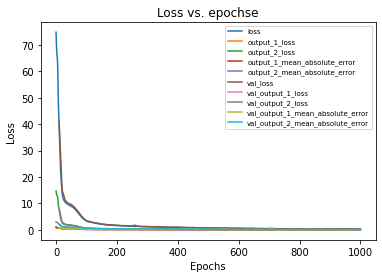

MAE 0.0296729926961883
r2_score 0.9974198529008769


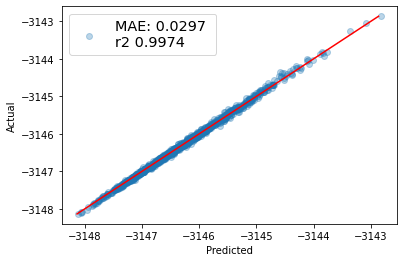

MAE 0.1224870266520861
r2_score 0.9957218899740342


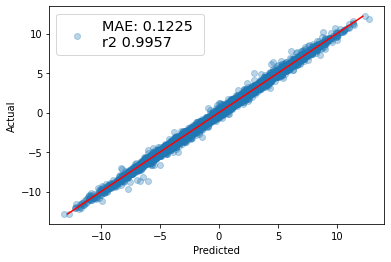

In [36]:
if do_training:
    pred_test = scaler.inverse_transform(model.predict(test_x)[0])
    true_test = scaler.inverse_transform(test_e)
    pred_test_grad = model.predict(test_x)[1]*scaler.scale_
    true_test_grad = test_g*scaler.scale_

    plot_history(hist, validation_freq=10, scale=scaler.scale_)
    plot_prediction(pred_test,true_test)
    plot_prediction(np.reshape(pred_test_grad,(-1,18)),np.reshape(true_test_grad,(-1,18)))

Please report on your achieved validation r2_score. You can change the hyperparemeters and play with the model definition. Eg. add a few layers or add a BatchNormalization layer after the Feature layer etc.

In [38]:
r2_score_energy = 0
r2_score_gradient = 0
# YOUR CODE HERE
r2_score_energy = 0.9974
r2_score_gradient = 0.9957

In [39]:
# 3 Points
assert r2_score_energy > 0.90
assert r2_score_gradient > 0.90

# MD Simulation

For time integration the so-called ["Verlet"](https://en.wikipedia.org/wiki/Verlet_integration) integration is used to integrate Newton's equations of motion.

The standard scheme of this algorithm is:

* Calculate ${\displaystyle {\vec {v}}\left(t+{\tfrac {1}{2}}\,\Delta t\right)={\vec {v}}(t)+{\tfrac {1}{2}}\,{\vec {a}}(t)\,\Delta t}$.

* Calculate ${\displaystyle {\vec {x}}(t+\Delta t)={\vec {x}}(t)+{\vec {v}}\left(t+{\tfrac {1}{2}}\,\Delta t\right)\,\Delta t}$.

* Derive ${\displaystyle {\vec {a}}(t+\Delta t)}$ from the interaction potential using ${\displaystyle {\vec {x}}(t+\Delta t)}$.

* Calculate ${\displaystyle {\vec {v}}(t+\Delta t)={\vec {v}}\left(t+{\tfrac {1}{2}}\,\Delta t\right)+{\tfrac {1}{2}}\,{\vec {a}}(t+\Delta t)\Delta t}$.

Here is an implementation in python with different time-integration.

In [40]:
class PotentialNN:
    
    unit_Bohr_A = 0.52917721090380
    unit_Hatree_eV = 27.21138624598853
    
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
    
    def __call__(self,x):
        # x in Bohr to eV
        x_A = x*self.unit_Bohr_A
        # call model
        eng, grad = self.model.predict(x_A)
        # inverse scaling
        eng = self.scaler.inverse_transform(eng)
        grad = grad*self.scaler.scale_
        # unit conversion to Hatree and Hatree/Bohr
        eng_B = eng/self.unit_Hatree_eV
        grad_BH = grad/self.unit_Hatree_eV*self.unit_Bohr_A
        return eng_B, grad_BH

In [41]:
class BatchEnsemble:
    
    unit_Bohr_A = 0.52917721090380
    unit_Bohr_m = 5.2917721090380e-11
    unit_me_kg = 9.109383701528e-31
    unit_Hatree_eV = 27.21138624598853
    unit_Hatree_J = 4.359744722207185e-18
    unit_atu_s = 2.418884326585747e-17
    unit_1u_me = 1.6605390666050e-27/9.109383701528e-31
    
    const_kB = 8.617333262e-5/27.21138624598853
    sign_force = -1.0
    
    def __init__(self, coord, mass, potential, velo = None):
        """Initial settings. All properties are in atomic units.
        
        Args:
            coord (np.array): Initial poisition of shape (batch, N, 3) in [Bohr]
            mass (np.array): Mass of particles (bath, N, 1) in [me]
            potential (callable): Potential model inputs coord and returns energies and gradients
                                  of shape (batch, 1) and (batch, N, 3) in [Hatree] and [Hatree/Bohr]
            velo (np.array): Initial velocities of shape (batch, N, 3)
        """
        
        # System properties
        self.mass = mass
        self.potential = potential
        self.number_particles = self.mass.shape[1]
        
        # Trajectory properties
        self.traj_x = [] # position in Bohr
        self.traj_v = [] # velicity in Bohr/atu
        self.traj_a = [] # acceleraton in Bohr/atu^2
        self.traj_t = [] # time in atu
        self.traj_p = [] # momentum in Bohr*me/atu
        self.traj_F = [] # force in Hatree/Bohr
        self.traj_E = [] # potential energy in Hatree
        self.traj_E_kin = [] # kinetic energy in Hatree
        self.traj_T = [] # Temperature in K
        
        #######################################################################
        
        # Set initial values i.e. traj[0]
        initial_x = coord
        if velo is None:
            initial_v = np.zeros_like(coord)
        else:
            initial_v = velo
        initial_p = initial_v*self.mass
        initial_eng, initial_grad = self.potential(initial_x)
        initial_force = self.sign_force*initial_grad
        initial_eng_kin = np.sum(np.sum(0.5*self.mass*initial_v*initial_v,axis=-1),axis=-1,keepdims=True)
        initial_temp = 2/3*initial_eng_kin/self.number_particles/self.const_kB
        initial_a = initial_force/self.mass
        
        # Append 0 time step
        self.traj_x.append(initial_x)
        self.traj_v.append(initial_v)
        self.traj_E.append(initial_eng)
        self.traj_F.append(initial_force)
        self.traj_a.append(initial_a)
        self.traj_t.append(0.0)
        self.traj_E_kin.append(initial_eng_kin)
        self.traj_T.append(initial_temp)
        self.traj_p.append(initial_p)
    
    def initialize_velocity(self, T):
        """Overwrite initial velcovity by Boltzmann distribution.
        
        Args:
            T (float): Temperature in K
        """
        initial_velo = np.random.standard_normal(self.traj_x[0].shape)
        initial_velo = initial_velo*np.sqrt(self.const_kB*T/self.mass)
        initial_eng_kin = np.sum(np.sum(0.5*self.mass*initial_velo*initial_velo,axis=-1),axis=-1,keepdims=True)
        initial_p = initial_velo*self.mass
        initial_T = 2/3*initial_eng_kin/self.number_particles/self.const_kB
        
        self.traj_v[0] = initial_velo
        self.traj_E_kin[0] = initial_eng_kin
        self.traj_T[0] = initial_T
        self.traj_p[0] = initial_p

In [42]:
class TimeIntegration:
     
    unit_atu_s = 2.418884326585747e-17
    const_kB = 8.617333262e-5/27.21138624598853
    
    def __init__(self,ensemble):
        self.ensemble = ensemble
    
    def propagate_timestep(self):
        pass

    def propagate(self, time_length, step_size):
        """Propagate ensemble.
        
        Args:
            time_length: Time of the simulation in [fs]
            step_size: Time step in [fs]        
        """
        #Repeat time step
        num_steps = int(time_length/step_size)
        
        # Map to atu
        time_length = time_length*1e-15/self.unit_atu_s
        step_size = step_size*1e-15/self.unit_atu_s
        print("Run MD for:", time_length, "a.t.u with steps:" ,step_size, "a.t.u")
        
          
        propagation_function = self.propagate_timestep
        
        # Run MD
        for i in range(num_steps):
            propagation_function(step_size)  
            if i%500==0:
                print("Steps done:",i)

In [43]:
class VerletIntegration(TimeIntegration):

    def propagate_timestep(self, delta_t):
        # time in atu
        
        t = self.ensemble.traj_t[-1] 
        x_t = self.ensemble.traj_x[-1]
        a_t = self.ensemble.traj_a[-1]
        v_t = self.ensemble.traj_v[-1]
        m = self.ensemble.mass
        N = self.ensemble.number_particles
        kB = self.const_kB
        sig_F = self.ensemble.sign_force
        
        v_t_dt_2 = v_t + 0.5*a_t*delta_t
        x_t_dt = x_t + v_t_dt_2*delta_t 
        
        e_t_dt, g_t_dt = self.ensemble.potential(x_t_dt)
        a_t_dt = sig_F*g_t_dt/m
        
        v_t_dt = v_t_dt_2 + 0.5*a_t_dt*delta_t
        e_kin_t_dt = np.sum(np.sum(0.5*m*v_t_dt*v_t_dt,axis=-1),axis=-1,keepdims=True)
        p_t_dt = v_t_dt*m
        T_dt = 2/3*e_kin_t_dt/N/kB

        # Add time-step
        self.ensemble.traj_x.append(x_t_dt)
        self.ensemble.traj_v.append(v_t_dt)
        self.ensemble.traj_a.append(a_t_dt)
        self.ensemble.traj_t.append(t + delta_t)
        self.ensemble.traj_F.append(sig_F*g_t_dt)
        self.ensemble.traj_E.append(e_t_dt)
        self.ensemble.traj_E_kin.append(e_kin_t_dt)
        self.ensemble.traj_T.append(T_dt)
        self.ensemble.traj_p.append(p_t_dt)

In [44]:
class BerendsenThermostat(TimeIntegration): 
    
    def __init__(self,ensemble,f_cool = 0,T0 = 300):
        """Make Time Integration with Berendsen Thermostat for Verlet.
        
        Args:
            ensemble: BatchEnsemble class
            f_cool: Colling coupling as frequency in [fs]
            T0: Temperature of bath [K]
        """
        self.ensemble=ensemble
        self.f_cool = f_cool/1e-15*self.unit_atu_s
        self.T0 = T0

    def propagate_timestep(self, delta_t):
        # time in atu
        
        t = self.ensemble.traj_t[-1] 
        x_t = self.ensemble.traj_x[-1]
        a_t = self.ensemble.traj_a[-1]
        v_t = self.ensemble.traj_v[-1]
        m = self.ensemble.mass
        N = self.ensemble.number_particles
        kB = self.const_kB
        sig_F = self.ensemble.sign_force
        f_cool = self.f_cool
        
        v_t_dt_2 = v_t + 0.5*a_t*delta_t
        
        e_kin_t_dt_2 = np.sum(np.sum(0.5*m*v_t_dt_2*v_t_dt_2,axis=-1),axis=-1,keepdims=True)
        T_dt_2 = 2/3*e_kin_t_dt_2/N/kB
        lamd = np.sqrt(1+f_cool*delta_t*(self.T0/T_dt_2-1))
        
        x_t_dt = x_t + v_t_dt_2*delta_t 
        
        e_t_dt, g_t_dt = self.ensemble.potential(x_t_dt)
        a_t_dt = sig_F*g_t_dt/m
        
        v_t_dt = v_t_dt_2 + 0.5*a_t_dt*delta_t
        v_t_dt = np.expand_dims(lamd,axis=-1)*v_t_dt
        e_kin_t_dt = np.sum(np.sum(0.5*m*v_t_dt*v_t_dt,axis=-1),axis=-1,keepdims=True)
        p_t_dt = v_t_dt*m
        T_dt = 2/3*e_kin_t_dt/N/kB

        # Add time-step
        self.ensemble.traj_x.append(x_t_dt)
        self.ensemble.traj_v.append(v_t_dt)
        self.ensemble.traj_a.append(a_t_dt)
        self.ensemble.traj_t.append(t + delta_t)
        self.ensemble.traj_F.append(sig_F*g_t_dt)
        self.ensemble.traj_E.append(e_t_dt)
        self.ensemble.traj_E_kin.append(e_kin_t_dt)
        self.ensemble.traj_T.append(T_dt)
        self.ensemble.traj_p.append(p_t_dt)

In [45]:
class NoseHooverThermostat(TimeIntegration):
    
    def __init__(self,ensemble, T0 = 300,Q=1e3):
        self.ensemble = ensemble
        self.thermo_NH_T = T0
        self.thermo_NH_Q = Q
        
        self.thermo_p = [np.zeros_like(self.ensemble.mass)]
        self.thermo_q = [np.zeros_like(self.ensemble.mass)]
    
    def propagate_timestep(self,delta_t):
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2577381/
        # Get variables from ensemble
        V = self.ensemble.potential
        m = self.ensemble.mass
        sign_f = self.ensemble.sign_force
        t = self.ensemble.traj_t[-1] 
        Q = self.thermo_NH_Q
        N = self.ensemble.number_particles
        x_t = self.ensemble.traj_x[-1]
        a_t = self.ensemble.traj_a[-1]
        v_t = self.ensemble.traj_v[-1]
        p_t = self.ensemble.traj_p[-1]
        f_t = self.ensemble.traj_F[-1]
        e_kin_t = self.ensemble.traj_E_kin[-1]
        
        pi_t = self.thermo_p[-1]
        eta_t = self.thermo_q[-1]
        g = 3*N
        gkT = g*self.const_kB*self.thermo_NH_T
        
        # dt/2
        pi_s = pi_t + delta_t/4*(np.sum(p_t*p_t,axis=-1,keepdims=True)/m - gkT)
        s = np.exp(-pi_s*delta_t/2/Q)
        eta_t_dt_2 = eta_t + pi_s*delta_t/2/Q
        pi_t_dt_2 = pi_s + delta_t/4*(np.sum(p_t*p_t*s*s,axis=-1,keepdims=True)/m- gkT)
        
        p_t_dt_2 = p_t*s + f_t*delta_t/2
        x_t_dt = x_t + p_t_dt_2/m*delta_t
        
        e_t_dt, g_t_dt = V(x_t_dt)
        f_t_dt = sign_f*g_t_dt
        a_t_dt = f_t_dt/m
        p_s = p_t_dt_2 + f_t_dt*delta_t/2
        
        # Bath for dt
        pi_ss = pi_t_dt_2 + delta_t/4*(np.sum(p_s*p_s,axis=-1,keepdims=True)/m - gkT)
        s = np.exp(-pi_ss*delta_t/2/Q)        
        eta_t_dt = eta_t_dt_2 + pi_ss*delta_t/2/Q        
        pi_t_dt = pi_ss + delta_t/4*(np.sum(p_s*p_s*s*s,axis=-1,keepdims=True)/m - gkT)
        
        p_t_dt = p_s*s
        v_t_dt = p_t_dt/m
        e_kin_t_dt = np.sum(np.sum(p_t_dt*p_t_dt/m/2,axis=-1),axis=-1,keepdims=True)
        T_t_dt = 2/3*e_kin_t_dt/N/self.const_kB
        t_dt = t + delta_t
        
        # Add time-step
        self.ensemble.traj_x.append(x_t_dt)
        self.ensemble.traj_v.append(v_t_dt)
        self.ensemble.traj_a.append(a_t_dt)
        self.ensemble.traj_t.append(t_dt)
        self.ensemble.traj_F.append(f_t_dt)
        self.ensemble.traj_E.append(e_t_dt)
        self.ensemble.traj_E_kin.append(e_kin_t_dt)
        self.ensemble.traj_T.append(T_t_dt)
        self.ensemble.traj_p.append(p_t_dt)
        self.thermo_p.append(pi_t_dt)
        self.thermo_q.append(eta_t_dt)

Now we can run a very simple MD simulation for a batch of molecules. We take the energy minimum and initialize a batch of molecules with temperature T. We also have to provide mass and the neural network potential in matching units. Please submit you notebook with `do_poropgate = False` and `show_trajectory = False`.

In [60]:
do_poropgate = False
show_trajectory = False
# YOUR CODE HERE
do_poropgate = False
show_trajectory = False

In [47]:
# Make a batch molecules.
lowest = np.argsort(energies)[0]
print("Energy Minimum",energies[lowest])
x_md = geos[lowest]
x_md = np.repeat(np.expand_dims(x_md,axis=0),10,axis=0)
x_md = x_md/PotentialNN.unit_Bohr_A
mass = np.array([[[12.0],[15.99491],[1.007825],[1.007825],[1.007825],[1.007825]]])*BatchEnsemble.unit_1u_me

# Setup Ensemble and 
potential = PotentialNN(model,scaler)
ensemble_md = BatchEnsemble(x_md, mass, potential)
ensemble_md.initialize_velocity(1000.0)
trajectory_md = VerletIntegration(ensemble_md)

Energy Minimum -3148.5957961


Run MD for: 41341.37333518131 a.t.u with steps: 41.341373335181316 a.t.u
Steps done: 0
Steps done: 500


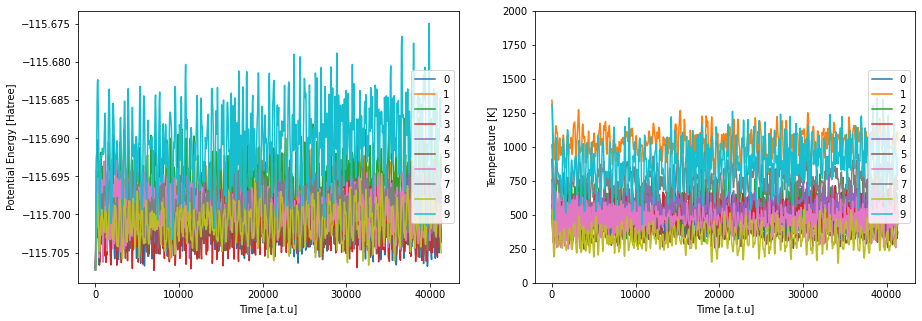

In [48]:
if do_poropgate:
    trajectory_md.propagate(1000,1)
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    for i in range(10):
        plt.plot(np.array(ensemble_md.traj_t),np.array(ensemble_md.traj_E)[:,i,0], label=str(i))
    plt.legend(loc="right")
    plt.xlabel("Time [a.t.u]")
    plt.ylabel("Potential Energy [Hatree]")
    plt.subplot(122)
    for i in range(10):
        plt.plot(np.array(ensemble_md.traj_t),np.array(ensemble_md.traj_T)[:,i,0], label=str(i))
    plt.legend(loc="right")
    plt.xlabel("Time [a.t.u]")
    plt.ylabel("Temperature [K]")
    plt.ylim([0,2000])
    plt.show()

We can look at a molecule from the batch with the `ase` viewer. You should see a new pannel where you can hit play and choose the number of frames per second.

In [49]:
if show_trajectory:
    import ase
    from ase.visualize import view
    traj_pos_md = np.array(ensemble_md.traj_x)[:,0,:,:]*0.52917721090380
    traj_pos_md_ase = [ase.Atoms(['C', 'O', 'H', 'H', 'H', 'H'],positions=x) for x in traj_pos_md]
    view(traj_pos_md_ase)

You notice a large spread in the initial temperatures. Have a look at the method `initialize_velocity` in the definition of the `BatchEnsemble` class. What could be a better way to initialized the velocities to achieve a specific kinetic energy or temperature. 

1. Set all $\forall v \in \mathbb{R}^3: v_{x,y,z} = v_0 $ constant.
2. Choose a $|v|$ from Maxwell-Boltzmann distribution and a random direction for each atom, remove the COM velocity and rescale according to desired temperature.
3. Set all $v = 0$ and adjust potential scale.

In [50]:
answer_md_v = 0 # choose the correct answer
# YOUR CODE HERE
answer_md_v = 2

In [51]:
# 1 Points
assert answer_md_v != 0

Now we run the MD Simulation with a thermostat. That means we can cool the system during the simulation.

In [52]:
potential = PotentialNN(model,scaler)
ensemble_md = BatchEnsemble(x_md, mass, potential)
ensemble_md.initialize_velocity(1000.0)
trajectory_md = BerendsenThermostat(ensemble_md,f_cool = 0.01, T0 = 100)

Run MD for: 82682.74667036263 a.t.u with steps: 41.341373335181316 a.t.u
Steps done: 0
Steps done: 500
Steps done: 1000
Steps done: 1500


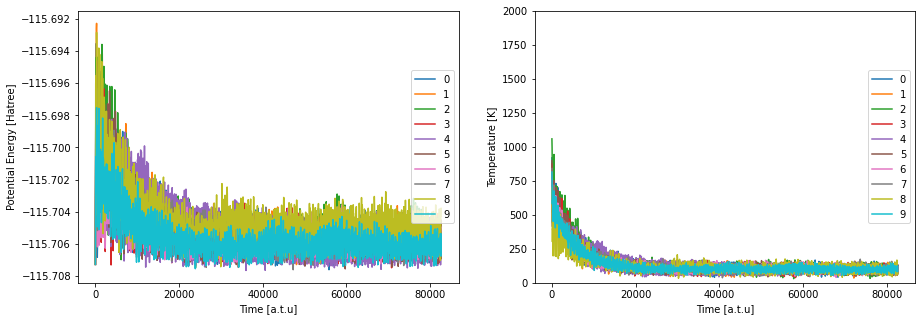

In [53]:
if do_poropgate:
    trajectory_md.propagate(2000,1)
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    for i in range(10):
        plt.plot(np.array(ensemble_md.traj_t),np.array(ensemble_md.traj_E)[:,i,0], label=str(i))
    plt.legend(loc="right")
    plt.xlabel("Time [a.t.u]")
    plt.ylabel("Potential Energy [Hatree]")
    plt.subplot(122)
    for i in range(10):
        plt.plot(np.array(ensemble_md.traj_t),np.array(ensemble_md.traj_T)[:,i,0], label=str(i))
    plt.legend(loc="right")
    plt.xlabel("Time [a.t.u]")
    plt.ylabel("Temperature [K]")
    plt.ylim([0,2000])
    plt.show()

In [54]:
if show_trajectory:
    import ase
    from ase.visualize import view
    traj_pos_md = np.array(ensemble_md.traj_x)[:,0,:,:]*0.52917721090380
    traj_pos_md_ase = [ase.Atoms(['C', 'O', 'H', 'H', 'H', 'H'],positions=x) for x in traj_pos_md]
    view(traj_pos_md_ase)

There is a second definition of a thermostat. Run the simulation and report your observation. We will explain it in the Q/A session. Unfortunately you have to have the NN trained and the MD running for answering this part (solved previous steps).

In [55]:
potential = PotentialNN(model,scaler)
ensemble_md = BatchEnsemble(x_md, mass, potential)
ensemble_md.initialize_velocity(1000.0)
trajectory_md = NoseHooverThermostat(ensemble_md,Q = 1e6, T0 = 100)

Run MD for: 206706.86667590658 a.t.u with steps: 41.341373335181316 a.t.u
Steps done: 0
Steps done: 500
Steps done: 1000
Steps done: 1500
Steps done: 2000
Steps done: 2500
Steps done: 3000
Steps done: 3500
Steps done: 4000
Steps done: 4500


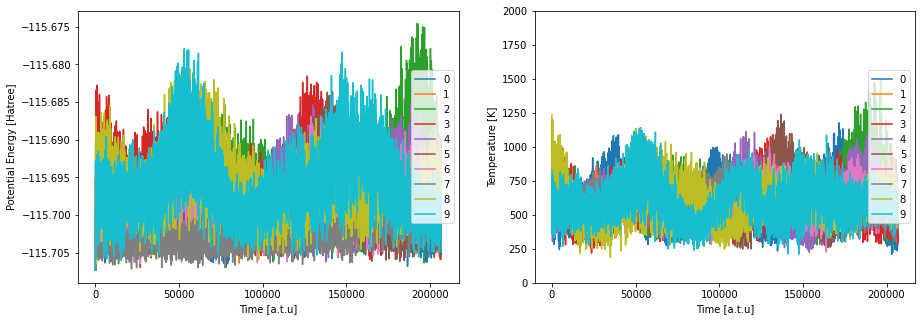

In [56]:
if do_poropgate:
    trajectory_md.propagate(5000,1)
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    for i in range(10):
        plt.plot(np.array(ensemble_md.traj_t),np.array(ensemble_md.traj_E)[:,i,0], label=str(i))
    plt.legend(loc="right")
    plt.xlabel("Time [a.t.u]")
    plt.ylabel("Potential Energy [Hatree]")
    plt.subplot(122)
    for i in range(10):
        plt.plot(np.array(ensemble_md.traj_t),np.array(ensemble_md.traj_T)[:,i,0], label=str(i))
    plt.legend(loc="right")
    plt.xlabel("Time [a.t.u]")
    plt.ylabel("Temperature [K]")
    plt.ylim([0,2000])
    plt.show()

In [62]:
answer_observation = ""
# YOUR CODE HERE
answer_observation = """
    The temperature is not converging to zero (cooling down) as with the previus methods, but is oscilatting up and down.
"""

In [58]:
# 1 Point
assert isinstance(answer_observation, str)

In [68]:
# 3 Points
assert do_training == False
assert do_poropgate == False
assert show_trajectory == False

NameError: name 'do_training' is not defined